In [2]:
import numpy as np
import pandas as pd
import pickle
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#import dataset and see how it looks like
df = pd.read_csv("../dataset/mbti_big5_clean.csv")
print(df.shape)
df.head()


(8672, 6)


,type,conscieniousness,agreeable,extraversion,neuroticism,openness
0,INFJ,43.52417819,58.68915806,an,95.56853657,68.2717645
1,INFJ,50.22031973,57.71273046,20.2788891,85.88187978,75.60278174
2,ENTP,37.61441377,53.04986179,19.2923702,97.24779521,76.6872109
3,INTP,55.88302211,62.36175274,33.68039782,77.35532718,73.16256345
4,INTJ,21.39582754,70.408671,56.05826003,89.56679917,72.92137874


In [4]:
# some sample has texts data
mask = df['extraversion'].str.contains('^\d*\.?\d*$', na = False)
df = df[mask]
df.head()

,type,conscieniousness,agreeable,extraversion,neuroticism,openness
1,INFJ,50.22031973,57.71273046,20.2788891,85.88187978,75.60278174
2,ENTP,37.61441377,53.04986179,19.2923702,97.24779521,76.6872109
3,INTP,55.88302211,62.36175274,33.68039782,77.35532718,73.16256345
4,INTJ,21.39582754,70.408671,56.05826003,89.56679917,72.92137874
5,ENTJ,15.7368388,47.37946064,55.7772194,96.28591317,69.24075453


In [5]:
# remove samples has text data on other traits
df = df[df['conscieniousness'].str.contains('^\d*\.?\d*$', na = False)]
df = df[df['agreeable'].str.contains('^\d*\.?\d*$', na = False)]
df = df[df['neuroticism'].str.contains('^\d*\.?\d*$', na = False)]
df = df[df['openness'].str.contains('^\d*\.?\d*$', na = False)]

In [6]:
mbti_cols = df['type'].str.extract('(?P<IE>[IE])(?P<SN>[SN])(?P<TF>[TF])(?P<PJ>[PJ])', expand = False)
mbti_cols.head()
df = mbti_cols.assign(conscieniousness=df['conscieniousness'],
                      agreeable=df['agreeable'],
                      neuroticism=df['neuroticism'],
                      openness=df['openness'],
                      extraversion=df['extraversion'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8488 entries, 1 to 8671
Data columns (total 9 columns):
IE                  8488 non-null object
SN                  8488 non-null object
TF                  8488 non-null object
PJ                  8488 non-null object
conscieniousness    8488 non-null object
agreeable           8488 non-null object
neuroticism         8488 non-null object
openness            8488 non-null object
extraversion        8488 non-null object
dtypes: object(9)
memory usage: 663.1+ KB


In [7]:
# transfer mbti to integers
mbti_dict = {'I':1, 'E':0, 'S':0, 'N':1, 'T':0, 'F':1, 'P':0, 'J':1}
mbti_dict_back = {v: k for k, v in mbti_dict.items()}

df['IE'] = df['IE'].apply(lambda x: mbti_dict[x])
df['PJ'] = df['PJ'].apply(lambda x: mbti_dict[x])
df['SN'] = df['SN'].apply(lambda x: mbti_dict[x])
df['TF'] = df['TF'].apply(lambda x: mbti_dict[x])

df.head()

,IE,SN,TF,PJ,conscieniousness,agreeable,neuroticism,openness,extraversion
1,1,1,1,1,50.22031973,57.71273046,85.88187978,75.60278174,20.2788891
2,0,1,0,0,37.61441377,53.04986179,97.24779521,76.6872109,19.2923702
3,1,1,0,0,55.88302211,62.36175274,77.35532718,73.16256345,33.68039782
4,1,1,0,1,21.39582754,70.408671,89.56679917,72.92137874,56.05826003
5,0,1,0,1,15.7368388,47.37946064,96.28591317,69.24075453,55.7772194


In [8]:
# unify datatypes
df = df.apply(pd.to_numeric)
df.dtypes

IE                    int64
SN                    int64
TF                    int64
PJ                    int64
conscieniousness    float64
agreeable           float64
neuroticism         float64
openness            float64
extraversion        float64
dtype: object

In [9]:
# see how data look like
df.describe()

,IE,SN,TF,PJ,conscieniousness,agreeable,neuroticism,openness,extraversion
count,8488.000000,8488.000000,8488.000000,8488.000000,8488.000000,8488.000000,8488.000000,8488.000000,8488.000000
mean,0.769321,0.861216,0.540528,0.396442,34.859276,50.606149,91.332269,69.594194,34.768475
std,0.421292,0.345742,0.498384,0.489187,17.656223,15.575845,10.306173,13.968651,16.157007
min,0.000000,0.000000,0.000000,0.000000,1.000000,3.658302,4.000000,2.000000,1.000000
25%,1.000000,1.000000,0.000000,0.000000,21.019192,39.437223,88.196674,60.609393,22.736694
50%,1.000000,1.000000,1.000000,0.000000,34.091767,50.857164,95.275233,71.218644,33.487382
75%,1.000000,1.000000,1.000000,1.000000,47.204290,61.806459,98.487059,80.074291,45.527647
max,1.000000,1.000000,1.000000,1.000000,95.165435,99.000000,99.000000,99.000000,94.242590


In [10]:
# the text of mbti dataset were collected from posts in 'personality cafe' forum, therefore,
# content in this type of psychology forum is highly possible relating to words with neuroticism.
# for a less noise distribution, I decided to delete some of samples that has neuroticism 90+
df_red = df.head(8200)
df_red = df_red[df_red['neuroticism']<80]
df_red.info()
df_temp = df.iloc[8201:]
df_red = df_red.append(df_temp)
df_red.info()
# 974/1261 around 0.77

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 3 to 8358
Data columns (total 9 columns):
IE                  974 non-null int64
SN                  974 non-null int64
TF                  974 non-null int64
PJ                  974 non-null int64
conscieniousness    974 non-null float64
agreeable           974 non-null float64
neuroticism         974 non-null float64
openness            974 non-null float64
extraversion        974 non-null float64
dtypes: float64(5), int64(4)
memory usage: 76.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1261 entries, 3 to 8671
Data columns (total 9 columns):
IE                  1261 non-null int64
SN                  1261 non-null int64
TF                  1261 non-null int64
PJ                  1261 non-null int64
conscieniousness    1261 non-null float64
agreeable           1261 non-null float64
neuroticism         1261 non-null float64
openness            1261 non-null float64
extraversion        1261 non-null float64
dtypes:

In [11]:
df_red.describe()

,IE,SN,TF,PJ,conscieniousness,agreeable,neuroticism,openness,extraversion
count,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000
mean,0.791435,0.846947,0.501190,0.411578,41.032324,63.278637,73.751061,71.292087,41.539847
std,0.406444,0.360182,0.500197,0.492315,17.443387,14.534725,14.341582,13.948985,16.846683
min,0.000000,0.000000,0.000000,0.000000,3.159586,8.839602,4.000000,14.567783,1.000000
25%,1.000000,1.000000,0.000000,0.000000,28.228784,54.345570,66.709667,63.469826,29.410574
50%,1.000000,1.000000,1.000000,0.000000,41.355316,64.673337,74.205833,73.798465,40.984155
75%,1.000000,1.000000,1.000000,1.000000,52.803015,73.629338,79.243662,81.194365,52.875185
max,1.000000,1.000000,1.000000,1.000000,95.165435,99.000000,99.000000,97.464683,94.242590


In [12]:
# preparing training
features = df_red.iloc[:, 0:3]
labels = df_red.iloc[:, 4:8]
print('feature shape :', features.shape)
print('labels shape :', labels.shape)

feature shape : (1261, 3)
labels shape : (1261, 4)


In [13]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, labels, 
                                                                            test_size=0.2, 
                                                                            random_state = 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1008, 3)
(253, 3)
(1008, 4)
(253, 4)


In [14]:
# multioutput regression model
model = MultiOutputRegressor(GradientBoostingRegressor(random_state=0))
model.fit(X_train, y_train)
scores = model.score(X_test, y_test)
print('scores:', scores)

scores: 0.000616782001944


In [15]:
# zero score problem analysis:
# 1. assume we have a perfect model, we only have 16 possible combinations of MBTI types, then input each combination
# would only result in fixed outpout; therefore, overall we would only have 16 possible arrangement of Big 5.
# 2. since current dataset has 1000+ samples, it's not reasonable to fit 1000+ samples to 16 exact combinations

# TO-DO:
# 1. training using neural network; take cost as a standard
# 2. reduce dataset size, to attain a minimum cost
# 3. text features to Big 5

In [16]:
# training using MLP regressor; take cost as a standard
model = MLPRegressor(hidden_layer_sizes=(50,50,50,50,50,50), solver='adam', verbose=True)
model.fit(X_train, y_train)
print('loss: ', model.loss_)
score = model.score(X_test, y_test)
print('Score: ', score)
# R^2 is negative, not useful
# not good enough, try reduce dataset

Iteration 1, loss = 2143.50471713
Iteration 2, loss = 2129.19064651
Iteration 3, loss = 2113.86568537
Iteration 4, loss = 2091.06367082
Iteration 5, loss = 2050.50709049
Iteration 6, loss = 1972.58587201
Iteration 7, loss = 1822.67289446
Iteration 8, loss = 1542.49831304
Iteration 9, loss = 1065.94312555
Iteration 10, loss = 444.10499533
Iteration 11, loss = 228.09455126
Iteration 12, loss = 241.62184300
Iteration 13, loss = 138.68866714
Iteration 14, loss = 157.53365039
Iteration 15, loss = 132.77393885
Iteration 16, loss = 127.81791147
Iteration 17, loss = 124.09478196
Iteration 18, loss = 118.62946411
Iteration 19, loss = 118.53609229
Iteration 20, loss = 116.81899924
Iteration 21, loss = 116.85652663
Iteration 22, loss = 115.96144891
Iteration 23, loss = 115.67444607
Iteration 24, loss = 115.61328776
Iteration 25, loss = 115.73304841
Iteration 26, loss = 115.71899137
Iteration 27, loss = 116.02830258
Training loss did not improve more than tol=0.000100 for two consecutive epochs. S

In [17]:
# reduce dataset
df_red2 = df.head(1500)
df_temp1 = df_red2.head(1200)
df_temp1 = df_temp1[df_temp1['neuroticism']<80]
df_temp1.info()
df_temp2 = df_red2.iloc[1201:]
df_red2 = df_temp1.append(df_temp2)
df_red2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 3 to 1203
Data columns (total 9 columns):
IE                  151 non-null int64
SN                  151 non-null int64
TF                  151 non-null int64
PJ                  151 non-null int64
conscieniousness    151 non-null float64
agreeable           151 non-null float64
neuroticism         151 non-null float64
openness            151 non-null float64
extraversion        151 non-null float64
dtypes: float64(5), int64(4)
memory usage: 11.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 3 to 1522
Data columns (total 9 columns):
IE                  450 non-null int64
SN                  450 non-null int64
TF                  450 non-null int64
PJ                  450 non-null int64
conscieniousness    450 non-null float64
agreeable           450 non-null float64
neuroticism         450 non-null float64
openness            450 non-null float64
extraversion        450 non-null float64
dtypes: float64(5

In [18]:
# preparing training
features = df_red2.iloc[:, 0:3]
labels = df_red2.iloc[:, 4:8]
print('feature shape :', features.shape)
print('labels shape :', labels.shape)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, labels, 
                                                                            test_size=0.2, 
                                                                            random_state = 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

feature shape : (450, 3)
labels shape : (450, 4)
(360, 3)
(90, 3)
(360, 4)
(90, 4)


In [19]:
model = MLPRegressor(hidden_layer_sizes=(50,50,50,50,50,50), solver='adam', verbose=True)
model.fit(X_train, y_train)
print('loss: ', model.loss_)
score = model.score(X_test, y_test)
print('Score: ', score)
# R^2 is worse than larger dataset

Iteration 1, loss = 2196.46431666
Iteration 2, loss = 2192.20285916
Iteration 3, loss = 2187.98840671
Iteration 4, loss = 2183.37962818
Iteration 5, loss = 2178.08793714
Iteration 6, loss = 2171.48022778
Iteration 7, loss = 2163.38144425
Iteration 8, loss = 2153.15669957
Iteration 9, loss = 2140.36567202
Iteration 10, loss = 2124.59113873
Iteration 11, loss = 2105.08871150
Iteration 12, loss = 2080.77313846
Iteration 13, loss = 2050.47287731
Iteration 14, loss = 2012.55861766
Iteration 15, loss = 1965.40713116
Iteration 16, loss = 1906.41205426
Iteration 17, loss = 1832.97453435
Iteration 18, loss = 1742.52905439
Iteration 19, loss = 1630.76758341
Iteration 20, loss = 1495.30047647
Iteration 21, loss = 1334.51623054
Iteration 22, loss = 1145.43494126
Iteration 23, loss = 931.96247161
Iteration 24, loss = 703.04161518
Iteration 25, loss = 479.53627253
Iteration 26, loss = 297.60973358
Iteration 27, loss = 207.95209393
Iteration 28, loss = 239.94811213
Iteration 29, loss = 323.29713033
I

In [20]:
# preparing training
features = df.iloc[:, 0:3]
labels = df.iloc[:, 4:8]
print('feature shape :', features.shape)
print('labels shape :', labels.shape)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, labels, 
                                                                            test_size=0.2, 
                                                                            random_state = 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

feature shape : (8488, 3)
labels shape : (8488, 4)
(6790, 3)
(1698, 3)
(6790, 4)
(1698, 4)


In [21]:
model = MLPRegressor(hidden_layer_sizes=(50,100,50), solver='adam', verbose=True)
model.fit(X_train, y_train)
print('loss: ', model.loss_)
score = model.score(X_test, y_test)
print('Score: ', score)
# R^2 score of original dataset is better than reduced dataset, possibly due to neuroticism correlation higher.

Iteration 1, loss = 2153.94540602
Iteration 2, loss = 1596.74227833
Iteration 3, loss = 449.51122826
Iteration 4, loss = 175.22995894
Iteration 5, loss = 147.15281450
Iteration 6, loss = 135.52766148
Iteration 7, loss = 125.82726023
Iteration 8, loss = 118.00451635
Iteration 9, loss = 112.26410441
Iteration 10, loss = 108.69481438
Iteration 11, loss = 107.28701284
Iteration 12, loss = 107.00339971
Iteration 13, loss = 106.83486725
Iteration 14, loss = 106.80187021
Iteration 15, loss = 106.71765818
Iteration 16, loss = 106.66983713
Iteration 17, loss = 106.66333430
Iteration 18, loss = 106.65106149
Iteration 19, loss = 106.58194215
Iteration 20, loss = 106.61364571
Iteration 21, loss = 106.58059893
Iteration 22, loss = 106.56013490
Iteration 23, loss = 106.56958113
Iteration 24, loss = 106.53221515
Iteration 25, loss = 106.55074421
Iteration 26, loss = 106.57366268
Iteration 27, loss = 106.59811247
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping

In [50]:
# big 5 score range of each mbti type
# RNN text to personality traits
df2 = pd.read_csv("../dataset/mbti_big5_clean.csv")
df2 = df2[df2['extraversion'].str.contains('^\d*\.?\d*$', na = False)]
df2 = df2[df2['conscieniousness'].str.contains('^\d*\.?\d*$', na = False)]
df2 = df2[df2['agreeable'].str.contains('^\d*\.?\d*$', na = False)]
df2 = df2[df2['neuroticism'].str.contains('^\d*\.?\d*$', na = False)]
df2 = df2[df2['openness'].str.contains('^\d*\.?\d*$', na = False)]
df2['extraversion'] = df2['extraversion'].apply(pd.to_numeric)
df2['conscieniousness'] = df2['conscieniousness'].apply(pd.to_numeric)
df2['agreeable'] = df2['agreeable'].apply(pd.to_numeric)
df2['neuroticism'] = df2['neuroticism'].apply(pd.to_numeric)
df2['openness'] = df2['openness'].apply(pd.to_numeric)

df_red2 = df2.head(8200)
df_temp1 = df_red2.head(8200)
df_temp1 = df_temp1[df_temp1['neuroticism']<80]
df_temp2 = df_red2.iloc[8201:]
df2 = df_temp1.append(df_temp2)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 3 to 8358
Data columns (total 6 columns):
type                974 non-null object
conscieniousness    974 non-null float64
agreeable           974 non-null float64
extraversion        974 non-null float64
neuroticism         974 non-null float64
openness            974 non-null float64
dtypes: float64(5), object(1)
memory usage: 53.3+ KB


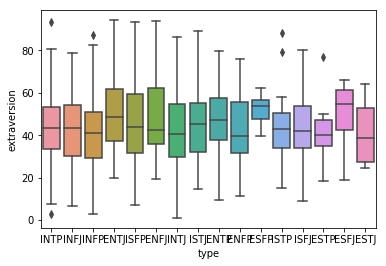

In [51]:
ax1 = sns.boxplot(x="type", y="extraversion", data=df2)
plt.show()

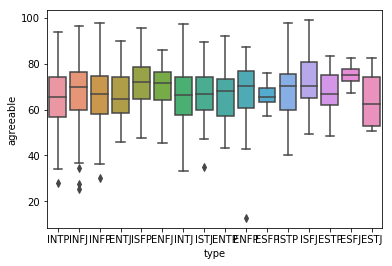

In [52]:
ax2 = sns.boxplot(x="type", y="agreeable", data=df2)
plt.show()

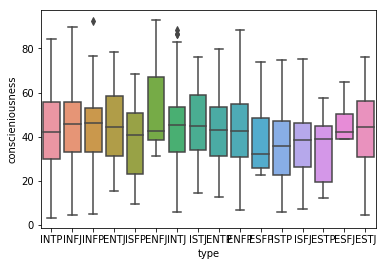

In [53]:
ax3 = sns.boxplot(x="type", y="conscieniousness", data=df2)
plt.show()

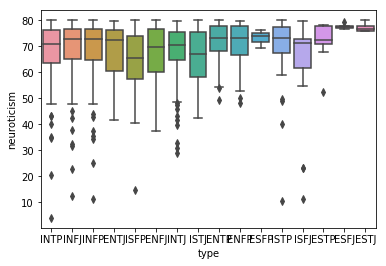

In [54]:
ax4 = sns.boxplot(x="type", y="neuroticism", data=df2)
plt.show()

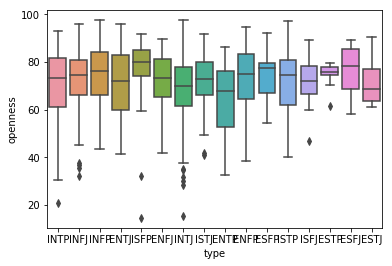

In [55]:
ax5 = sns.boxplot(x="type", y="openness", data=df2)
plt.show()

In [68]:
temp = df2.loc[df2['type']=='ISTJ']
temp = temp.describe()
#temp = temp.loc[df2['25%', '75%']]
print(temp.loc[{'25%','75%'}])

     conscieniousness  agreeable  extraversion  neuroticism   openness
75%         58.886564  74.380373     54.984032    75.621698  80.006546
25%         33.894785  59.695415     32.226462    57.994315  66.120118


In [70]:
# each mbti score looks like have a fair range of big 5 scores
mbti_ls = ['ISTJ', 'ISFJ', 'INFJ', 'INTJ', 'ISTP','ISFP','INFP', 'INTP', 
           'ESTJ', 'ESFJ', 'ENFJ', 'ENTJ', 'ESTP', 'ESFP', 'ENFP', 'ENTP']
mbti_big5 = {}
for mbti in mbti_ls:
    df_temp = df2.loc[df2['type']==mbti]
    df_temp = df_temp.describe()
    df_temp = df_temp.loc[{'25%', '75%'}]
    mbti_big5[mbti] = df_temp
                             
print(mbti_big5)

{'ISTJ':      conscieniousness  agreeable  extraversion  neuroticism   openness
75%         58.886564  74.380373     54.984032    75.621698  80.006546
25%         33.894785  59.695415     32.226462    57.994315  66.120118, 'ISFJ':      conscieniousness  agreeable  extraversion  neuroticism   openness
75%         46.229723  80.754366     53.827427    72.868382  78.235369
25%         26.350470  64.852975     34.019136    61.527105  66.345386, 'INFJ':      conscieniousness  agreeable  extraversion  neuroticism   openness
75%         55.721780  76.448219     54.495715    76.777890  80.750981
25%         32.861398  59.955331     30.439787    65.161842  65.993680, 'INTJ':      conscieniousness  agreeable  extraversion  neuroticism   openness
75%         53.347772  74.280020     54.521510    75.650829  78.002030
25%         32.962947  57.729641     29.510647    64.743814  61.676788, 'ISTP':      conscieniousness  agreeable  extraversion  neuroticism   openness
75%         47.222518  75.549843